<a href="https://colab.research.google.com/github/eliasd/speedpred/blob/master/CommaSpeedPrediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/My\ Drive/Creative/speedpred

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Creative/speedpred


In [ ]:
! git fetch origin master
! git reset --hard FETCH_HEAD
! git clean -df

From https://github.com/eliasd/speedpred
 * branch            master     -> FETCH_HEAD
HEAD is now at 4b957a9 Merge branch 'master' of https://github.com/eliasd/speedpred


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from dataset import get_pre_processed_dataset
from model import get_speed_prediction_network

### Getting the dataset

#### - Option #1: Shuffle the entire dataset, then select the train / val / test datasets.

In [ ]:
# Dataset size:
# if window_size = 4, then 5100 elements.
ds = get_pre_processed_dataset()

# Most of the time in this cell is spent counting 
# the number of elements in the dataset.
DS_SIZE = sum(1 for _ in ds)
print(f'Number of elements: {DS_SIZE}')

train_size = int(0.7 * DS_SIZE)
val_size = int(0.15 * DS_SIZE)
test_size = int(0.15 * DS_SIZE)
print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Test size: {test_size}')

# Shuffle dataset.
ds = ds.shuffle(buffer_size=DS_SIZE)

# Get training set.
train_ds = ds.take(train_size)

# Get validation and test sets.
full_test_ds = ds.skip(train_size)
val_ds = full_test_ds.take(val_size)
test_ds = full_test_ds.skip(test_size)

## TODO:
# - experiment with different tools (prefetch, cache) to speed up tf.data pipeline
#   performance
# - figure out how to program model training "restarts" (hypothesis: this 
#   is what lead to the sharp drop in loss from epoch 8 to epoch 9)
# - Create some cool graphs: (1) mse loss vs. epoch, (2) groundtruth test speed & pred 
#     test speed vs. test frame number,

Number of elements: 5100
Train size: 3570
Validation size: 765
Test size: 765


#### - Option #2: Select the last 15% of the dataset as the test set; then shuffle & select validation & train sets.

In [ ]:
# Dataset size:
# if window_size = 4, then 5100 elements.
# 
# Note: we add the .cache and .prefetch calls to improve datapipeline performance.
ds = get_pre_processed_dataset().cache('./cache/').prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Most of the time in this cell is spent counting 
# the number of elements in the dataset.
DS_SIZE = sum(1 for _ in ds)
print(f'Number of elements: {DS_SIZE}')

train_size = int(0.7 * DS_SIZE)
val_size = int(0.15 * DS_SIZE)
train_and_val_size = int(0.85 * DS_SIZE)
test_size = int(0.15 * DS_SIZE)

print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Training & Validation size: {train_and_val_size}')
print(f'Test size: {test_size}')


# Get training & validation set, shuffle it, and split it.
train_and_val_ds = ds.take(train_and_val_size).shuffle(buffer_size=train_and_val_size)
train_ds = train_and_val_ds.take(train_size)
val_ds = train_and_val_ds.skip(train_size)

# Get test set.
test_ds = ds.skip(train_and_val_size)

## TODO:
# - figure out how to program model training "restarts" (hypothesis: this 
#   is what lead to the sharp drop in loss from epoch 8 to epoch 9)

Number of elements: 5100
Train size: 3570
Validation size: 765
Training & Validation size: 4335
Test size: 765


### -- Fitting the Model

In [ ]:
model = get_speed_prediction_network()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mse'])

history = model.fit(train_ds.batch(2), epochs=8, validation_data=val_ds.batch(2))

Epoch 1/8
1785/1785 [==============================] - 427s 239ms/step - loss: 106.0380 - mse: 106.0380 - val_loss: 66.8401 - val_mse: 66.8401
Epoch 2/8
1785/1785 [==============================] - 427s 239ms/step - loss: 70.5660 - mse: 70.5660 - val_loss: 69.8543 - val_mse: 69.8543
Epoch 3/8
1785/1785 [==============================] - 425s 238ms/step - loss: 69.1564 - mse: 69.1564 - val_loss: 59.2234 - val_mse: 59.2234
Epoch 4/8
1785/1785 [==============================] - 426s 239ms/step - loss: 26.2091 - mse: 26.2091 - val_loss: 9.8727 - val_mse: 9.8727
Epoch 5/8
1785/1785 [==============================] - 427s 239ms/step - loss: 10.1739 - mse: 10.1739 - val_loss: 4.3152 - val_mse: 4.3152
Epoch 6/8
1785/1785 [==============================] - 426s 239ms/step - loss: 6.7785 - mse: 6.7785 - val_loss: 2.7558 - val_mse: 2.7558
Epoch 7/8
1785/1785 [==============================] - 427s 239ms/step - loss: 5.0850 - mse: 5.0850 - val_loss: 1.4117 - val_mse: 1.4117
Epoch 8/8
1785/1785 [==

## -- Evaluating the Model

#### MSE training history (MSE vs. epoch)

In [ ]:
print(f"Keys of history: {history.history.keys()}")

Keys of history: dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


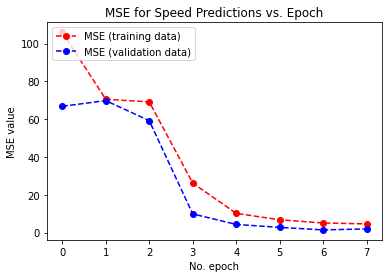

In [ ]:
# Plot history: MSE
plt.plot(history.history['mse'], 'ro--', label='MSE (training data)')
plt.plot(history.history['val_mse'], 'bo--', label='MSE (validation data)')
plt.title('MSE for Speed Predictions vs. Epoch')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#### MSE on the train dataset.

In [ ]:
model.evaluate(train_ds.batch(2))

1785/1785 [==============================] - 58s 32ms/step - loss: 1.8410 - mse: 1.8410


[1.8410160541534424, 1.8410160541534424]

#### MSE on the validation dataset.

In [ ]:
model.evaluate(val_ds.batch(2))

383/383 [==============================] - 12s 33ms/step - loss: 1.9302 - mse: 1.9302


[1.9302341938018799, 1.9302341938018799]

#### MSE on the test dataset.

In [ ]:
model.evaluate(test_ds.batch(2))

383/383 [==============================] - 26s 68ms/step - loss: 12.0183 - mse: 12.0183


[12.01831340789795, 12.01831340789795]

#### Predicted Speed vs. Groundtruth on test dataset.

In [ ]:
test_groundtruth_speed = []
test_predicted_speed = []
for window, labels in test_ds:
  preds = model(tf.expand_dims(window, 0))

  test_groundtruth_speed.extend(labels.numpy().tolist())
  test_predicted_speed.extend(preds.numpy()[0].tolist())

image_indexes = list(range(len(test_groundtruth_speed)))

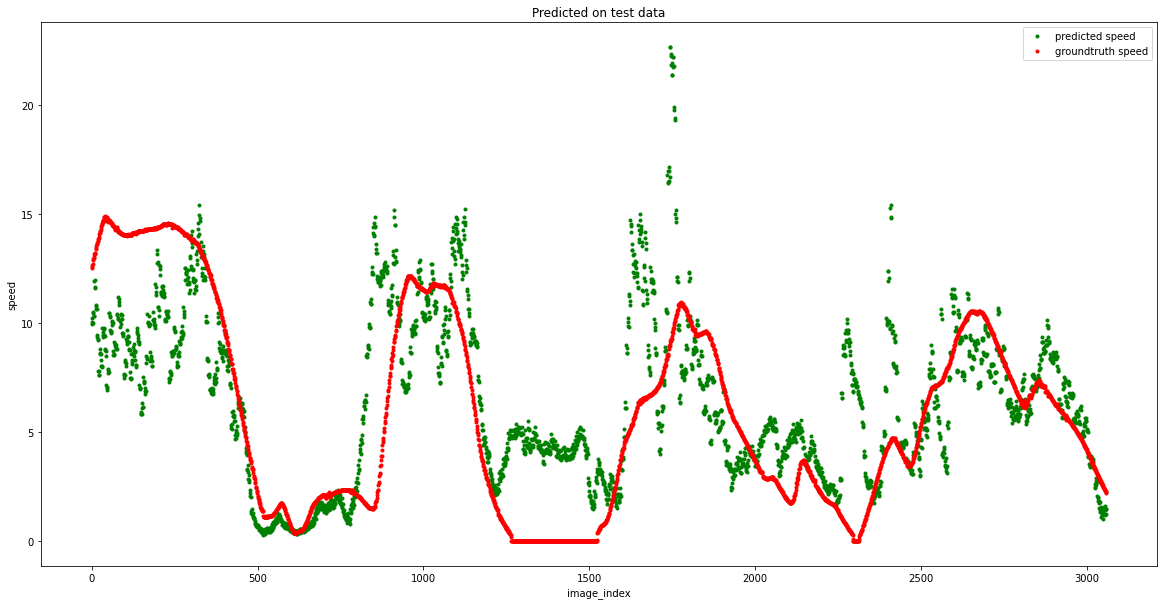

In [ ]:
# Plot predicted speed vs. groundtruth.
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(image_indexes, test_predicted_speed, 'g.')
plt.plot(image_indexes, test_groundtruth_speed, 'r.')
plt.xlabel('image_index')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'groundtruth speed'], loc='upper right')
plt.show()
plt.close()